# X1 Segmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

### Download the data from [GDrive](https://drive.google.com/file/d/1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g/view?usp=drivesdk) into your local folder

### or download the data from the notebook

In [ ]:
import gdown
# https://drive.google.com/file/d/1sVATyJhuX0UEdtd07gDnVTmg5xu1mp-g/view?usp=drive_link
# Google Drive file ID from the shareable link
file_id = "1sVATyJhuX0UEdtd07gDnVTmg5xu1mp"  # Replace with actual file ID
output_path = "./01_segmentation.tar.gz"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Download file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output_path, quiet=False)

## Let’s load the data and display some examples

In [6]:
file_path = '/mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/'

print("Folders in file_path:")
folders = [f for f in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, f))]
for folder in folders[:5]:
    print(f"- {folder}")

Folders in file_path:
- image_batch_52494658464_20240403
- image_batch_5254823359_20240403
- image_batch_52136360101_20240403
- image_batch_52393632444_20240403
- image_batch_52048343522_20240403

## Get all .h5 files from all subfolders

In [7]:

h5_files = []
for folder in folders:
    folder_path = os.path.join(file_path, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    h5_files.extend([os.path.join(folder_path, f) for f in files])

print(f"\nFound {len(h5_files)} .h5 files:")
for f in h5_files[:5]:  # Print first 5 files as example
    print(f"- {f}")
if len(h5_files) > 5:
    print("...")


Found 128 .h5 files:
- /mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/image_batch_52494658464_20240403/image_batch.h5
- /mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/image_batch_5254823359_20240403/image_batch.h5
- /mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/image_batch_52136360101_20240403/image_batch.h5
- /mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/image_batch_52393632444_20240403/image_batch.h5
- /mnt/data/insync/braunphil/Public/datascience_miniproject/optimal_Au/images/image_batch_52048343522_20240403/image_batch.h5
...

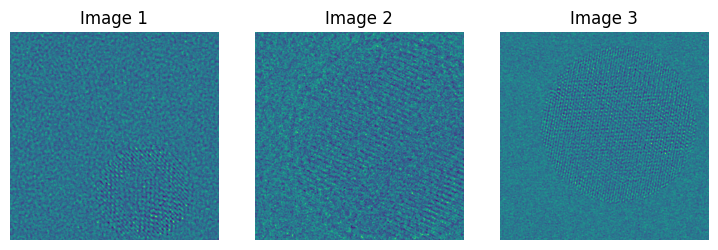

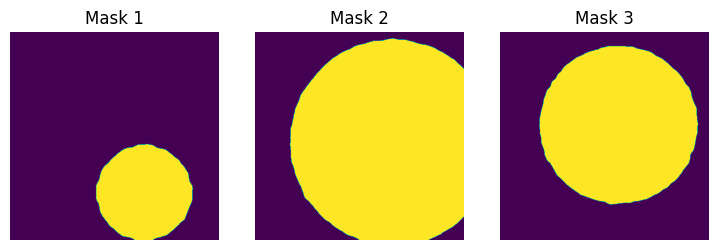

In [8]:
file_names = h5_files[0]

with h5.File(file_names, 'r') as f:
    d = f['train_batch'][...]
    m = f['mask_batch'][...]
   

fig, axes = plt.subplots(1, 3, figsize=(15/2, 5/2))
for i in range(3):
    axes[i].imshow(d[i])
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')
plt.tight_layout()
plt.show()
# Plot first 3 masks
fig, axes = plt.subplots(1, 3, figsize=(15/2, 5/2))
for i in range(3):
    axes[i].imshow(m[i])
    axes[i].axis('off') 
    axes[i].set_title(f'Mask {i+1}')
plt.tight_layout()
plt.show()

# %%

In [10]:
d.shape, m.shape

((64, 512, 512), (64, 512, 512))

In [13]:
class SegmentationDataset:
    def __init__(self, file_paths):
        self.file_paths = file_paths
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5.File(file_path, 'r') as f:
            # Load image and mask from h5 file
            image = f['train_batch'][...]
            mask = f['mask_batch'][...]
        return image, mask

# Create dataset instance
dataset = SegmentationDataset(h5_files)

# Test loading first item
images, masks = dataset[0]
print(f"Loaded images shape: {images.shape}")
print(f"Loaded masks shape: {masks.shape}")


Loaded images shape: (64, 512, 512)
Loaded masks shape: (64, 512, 512)

In [14]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(128, 64)
        
        # Final output
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)
        conv5 = self.conv5(pool4)
        
        # Decoder with skip connections
        up4 = self.up4(conv5)
        up4 = torch.cat([up4, conv4], dim=1)
        up4 = self.upconv4(up4)
        
        up3 = self.up3(up4)
        up3 = torch.cat([up3, conv3], dim=1)
        up3 = self.upconv3(up3)
        
        up2 = self.up2(up3)
        up2 = torch.cat([up2, conv2], dim=1)
        up2 = self.upconv2(up2)
        
        up1 = self.up1(up2)
        up1 = torch.cat([up1, conv1], dim=1)
        up1 = self.upconv1(up1)
        
        out = self.outconv(up1)
        return out

# Create model instance
model = UNet(in_channels=1, out_channels=1)



In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders
batch_size = 4
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Training parameters
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print statistics every 10 batches
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Print epoch statistics
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] complete. Average Loss: {epoch_loss:.4f}')

print('Training finished!')
